[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/soloyant/deltax_workshop_2024/blob/main/tutorials/2_SedimentTransport_Dorado/ex2_dorado_unsteady.ipynb)

# *dorado* Example 2 - unsteady simulation with unstructured grid


In this example, we will be routing our particles in an unsteady flow field derived from our previous ANUGA simulation. If you were unable to finish the previous exercise, the results data can be found in the parent directory under model_outputs.

**Note: the below code sets the directory relative to where this script is stored. Make sure that you set the different directories relative to where your data is stored.**

First, we import the required packages and set our directories

In [1]:
import sys

if 'google.colab' in sys.modules:
  # In case the notebook is opened in google collab, here we download/install all the files we need behind the scenes
  try:
      import os
      os.chdir('/content')
      # Grab workbook files into colab directory
      !git clone https://github.com/soloyant/deltax_workshop_2024.git
      # Install everything using some bash scripts
      !/bin/bash /content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utils/anuga_tools/install_anuga_colab.sh
      os.chdir('/content/deltax_workshop_2024/tutorials/2_SedimentTransport_Dorado/')
  except:
      pass

In [2]:
from __future__ import division, print_function, absolute_import
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import dorado
import matplotlib
from matplotlib import pyplot as plt
import os
import anuga
import dorado.particle_track as pt
import dorado.routines as drt
import json
import geopandas as gpd
from netCDF4 import Dataset
import matplotlib.tri as tri
from matplotlib.path import Path
from utils import dorado_visualization_tools as dorado_dvt
# from utils import data_plots as dpt


# get working directory (where the script is located)
par_dir = os.getcwd()
workshop_dir = os.path.abspath(os.path.join(par_dir,".."))

# define here the directory where your anuga files are saved. This path should lead you to the folder where 'data'
model_data = os.path.join(workshop_dir, '1_HydrodynamicModeling_ANUGA/data/collab')

# define the name of your sww-file generated by ANUGA
swwname = '20210327000000_DX_Workshop_1_days.sww'

# this is the path to where the sww-file is stored (here we use the default solution that is located in the 'anuga_data' folder
anuga_out_dir = os.path.join(workshop_dir, '1_HydrodynamicModeling_ANUGA/model_outputs/collab')

# Create a subfolder to save the output data:
subfolder = 'Nourishment_analysis_unsteady'
try:
    os.makedirs(os.path.join(par_dir, subfolder))
except:
    pass

# Import tools from the anuga segment of the workshop
import sys
anuga_utils_dir = os.path.join(workshop_dir, '1_HydrodynamicModeling_ANUGA/utils')
sys.path.append(anuga_utils_dir)
import data_processing_tools as anuga_dpt


### Define scenarios

Here we can define the theta used in the model. You can rerun the script by adjust the theta to inspect where the particles are going for the different scenarios. We create a subfolder here to save the dorado output for each theta. 

In [3]:
theta = 1.0

outname = 'Nourish_t%s' % (theta)

mydir = os.path.join(par_dir, subfolder,outname)
try:
    os.makedirs(mydir)
except:
    pass

print('This is your output folder path:', mydir)

This is your output folder path: /Users/soloy/Documents/GitHub/deltax_workshop_2024/tutorials/2_SedimentTransport_Dorado/Nourishment_analysis_unsteady/Nourish_t1.0


### Load Model Outputs

First, we import the domain generated during the DEM processing step to clip our model results to the area that we are intested in:

In [4]:
f_domain = os.path.join(model_data, 'dxws_domain.shp')
domain_gdf = gpd.read_file(f_domain)
# transform into list to be used in dorado functions
domainPolygon = np.asarray(domain_gdf.geometry[0].boundary.xy).T.tolist()

Now we will read the output data from ANUGA and inpsect and extract the data.

In [5]:
# read the netcdf-file (.sww) created in the ANUGA simulation
data = Dataset(os.path.join(anuga_out_dir, swwname))
print('This is the data structure of the ANUGA output file:', data)

This is the data structure of the ANUGA output file: <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    institution: Geosciences Australia
    description: Output from anuga.file.sww suitable for plotting
    smoothing: Yes
    vertices_are_stored_uniquely: False
    order: 2
    revision_number: No git sha available
    revision_date: No git date available
    anuga_version: 3.0
    starttime: 0.0
    xllcorner: 651107.0144164033
    yllcorner: 3247255.312158878
    zone: -1
    false_easting: 500000
    false_northing: 10000000
    datum: wgs84
    projection: UTM
    units: m
    dimensions(sizes): number_of_volumes(18845), number_of_triangle_vertices(9587), number_of_vertices(3), numbers_in_range(2), number_of_points(9587), number_of_timesteps(25)
    variables(dimensions): float32 x(number_of_points), float32 y(number_of_points), int32 volumes(number_of_volumes, number_of_vertices), float32 elevation(number_of_points), float32

In [6]:
# extract the lower left corner coordinates to correct for the volume coordinates
x_min = data.xllcorner
y_min = data.yllcorner

Take your time to inspect the structure of the dataset. Which are the necessary data to run dorado?



Now we need to interpolate the data from our ANUGA grid onto the dorado (rectangular) grid of a grid cell size of our choice. Here, we use an function *anuga.utilities.plot_utils.get_centroids()* that extracts the model quantities at the cell centers. If we used the above Dataset()-function, we would need to triangulate the coordinates from the triangular grid to the rectangular grid first.

In [7]:
swwvals = anuga.utilities.plot_utils.get_centroids(os.path.join(anuga_out_dir,swwname), timeSlices = 'all')
# Query values: time, x, y, stage, elev, height, xmom, ymom, xvel, yvel, friction, vel, etc

We extract the time array from our simulation and combine our coordinates into a list of tuples. This is the expected format for coordinates in the following functions.

In [8]:
# Extract the time and coordinates of the grid saved as distance from the lower left corner.
time = swwvals.time
x = swwvals.x + x_min
y = swwvals.y + y_min

# Finally we make a list with the cell points called 'coordinates'
coordinates = [(x[i], y[i]) for i in list(range(len(x)))]


#### Grid interpolation for *dorado*
Now that we have the data we need, we can convert it into the format needed by dorado. This will include gridding the hydrodynamic outputs and transforming our geospatial coordinates into “array index” coordinates.

Choose a grid cell size for your new mesh. You can play with this number to see how the interpolation changes.

In [9]:
grid_size = 25 # meters

Now we interpolate the data onto the new rectangluar grid by using the particle.track functionality *'unstruct2grid()'*,  which uses inverse-distance-weighted interpolation to create a Cartesian grid the same size as our model’s extent. To use this function, we need to provide: 
- a list of coordinates (as tuples)
- The unstructured data we want to be gridded (here we start with elevation)
- The desired grid size of the resulting rasters
- The number of nearest neighbors *k* to use in the interpolation. If *k=1*, we use only the nearest datapoint, whereas higher values (default is *k=3*) interpolate the data into a smoother result.

*'unstruct2grid()'* returns a gridded array of our data and a nearest-neighbor interpolation function for gridding additional             quantities *'myInterp'*.

The resulting interpolation function myInterp (after building the nearest-distance tree), which will be considerably faster than calling unstruct2grid again if we are gridding additional datasets. This function assumes data have the same coordinates, grid size, and *k*.

In [10]:
# extract the bed elevations
elev = swwvals.elev

# Use IDW interpolation interpolate unstructured data into uniform grid
myInterp, bathy = pt.unstruct2grid(coordinates, elev , grid_size, 3,boundary=domainPolygon, crop=True)
print(np.shape(bathy))

(775, 838)


Here we extract the other needed variables for our dorado simulation: 

In [11]:
# water depth
depth = swwvals.height

# water level
stage = swwvals.stage

# discharge x-direction
qx = swwvals.xmom

# discharge y-direction
qy = swwvals.ymom

#### Define seeding locations

Next we need to define a seeding locations for our particles. If you’re modeling a real domain, it may be easier to figure out a good release location by opening some GIS software and finding the coordinates of that location. 

Here, we use the discharge boundary as our seeding location. To do this, we first need to load the discharge transect from the ANUGA tutorial and transform them into a list: 

In [12]:
# set the path to our file
f_seeding_points = os.path.join(model_data, 'discharge_transect.shp')

# import the file using the gdp package
seeding_points_gdf = gpd.read_file(f_seeding_points)

# transform our shape-file into a list
seeding_points_loc = np.asarray(seeding_points_gdf.geometry[0].xy).T.tolist()

# print the locations to inspect
print(seeding_points_loc)

[[667279.313355803, 3266508.6850163136], [668560.0948551947, 3266560.9169023586]]


Check if the coordinates make sense. 

Next, we need to transform the coordinates into the indices on our rectangular grid using the function *particle_track.coord2ind()* to convert your coordinates into array indices. 
This function requires: 
- Coordinates to be converted, as a list [] of tuples
- The location of the lower left corner of your rasters (i.e. the origin). If you used unstruct2grid to generate rasters, this location will be [(min(x), min(y))]. Otherwise, if you’re loading data from e.g. a GeoTIFF, the lower left corner will be stored in the .tif metadata and can be accessed by GIS software or gdalinfo from the GDAL package.

We assume in all of these functions that the coordinates you’re using are (at least locally) flat. We do not account for the curvature of the Earth in very large domains. Hopefully you are using a projected coordinate system (here we are using meters UTM), or at least willing to accept a little distortion. Note that this coord2ind requires units of either meters or decimal degrees.

In [13]:
seedinds = pt.coord2ind(seeding_points_loc, (x_min, y_min), np.shape(bathy), grid_size)


The locations might not be in the correct locations. Here we will choose only the first one:

In [14]:
seed_locs = seedinds[0]

Alternatively, you can select the seeding locations on the map:

In [15]:
if 'google.colab' not in sys.modules:
    # Convert model domain polygon to WGS84 to be able to display it on the next map
    f_seeding_points = os.path.join(mydir, 'seeding_points.shp')
    domain_gdf_4326 = domain_gdf.to_crs(epsg=4326)
    domain_polygon_4326 = np.asarray(domain_gdf_4326.geometry[0].boundary.xy).T
    anuga_dpt.draw_points_in_polygon(filename=f_seeding_points, epsg=32615, domain_polygon=domain_polygon_4326)



Map(center=[29.5, -91.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Button(description='Save Points to Shapefile', style=ButtonStyle())

Output()

In [16]:
if 'google.colab' not in sys.modules:
    # import the file using the gdp package
    seeding_points_gdf = gpd.read_file(f_seeding_points).explode(ignore_index = True, index_parts=True).drop(columns=['id'])
    
    # transform our shape-file into a list
    seeding_points_loc = np.asarray([seeding_points_gdf.geometry.x.values, seeding_points_gdf.geometry.y.values]).T.tolist()
    
    # print the locations to inspect
    print(seeding_points_loc)
    
    seedinds = pt.coord2ind(seeding_points_loc, (x_min, y_min), np.shape(bathy), grid_size)
    seed_locs = seedinds

[[666293.0800668439, 3258611.594944182]]


Let's look at the new grid and the interpolated elevations to verify that everthing worked:

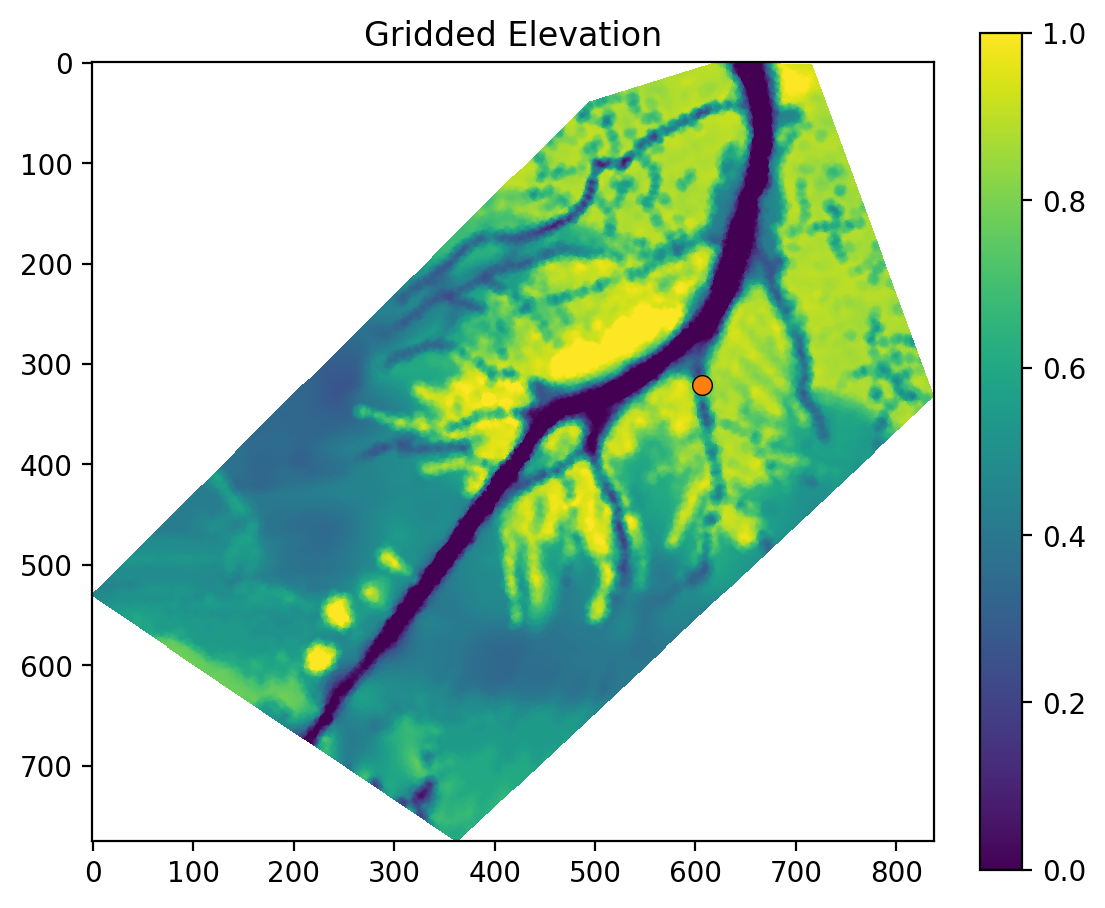

In [17]:
plt.figure(figsize=(6,6), dpi=200)
plt.imshow(bathy, vmin = -4, vmax = 1)

for ii in range(len(seedinds)):
    plt.scatter(seedinds[ii][1], seedinds[ii][0], c='tab:orange',
                                edgecolors='black', s=50, linewidths=0.5)
plt.colorbar(fraction=0.045)
plt.title('Gridded Elevation')

# save the figure in your output folder
plt.savefig(os.path.join(mydir, 'Map_seeding_point.png' ),bbox_inches='tight')

### Define the Model Parameters

Now that we have pre-converted the input data we need, let’s set up the particle routing to be run. We do this using the *particle_track.modelParams()* class, in which we populate the attributes to suit our application. This includes the gridded hydrodynamic outputs from above, the grid size dx, and tuning parameters which influence our random walk.

In [18]:
# Start populating particle model with settings
params = pt.modelParams()

# Constants
params.dx = grid_size
params.theta = theta
params.gamma = 0.0
params.dry_depth = 0.01
params.model = 'Anuga'
params.diff_coeff = 0.0
params.verbose = False
params.topography = bathy

The next step is to define the simulation run time. Here, we need to define the time-steps that we will seed our particles and the number of particles per seeding event. Let's inspect the time-steps saved in our ANUGA output. Those are in seconds:

In [19]:
print(time)

[    0.  3600.  7200. 10800. 14400. 18000. 21600. 25200. 28800. 32400.
 36000. 39600. 43200. 46800. 50400. 54000. 57600. 61200. 64800. 68400.
 72000. 75600. 79200. 82800. 86400.]


Now we define our seeding events and total simulation time for *dorado*:

In [20]:
# number of seedings (here every output time-step) - the number defines the number of time-steps 
# (e.g., if you set it to 5, it will seed in the first 5 time-steps of your simulation)
num_seed_steps = 24

# Number of total run time in output time-steps
num_total_steps = 24

# number of particles per seeding event
Np_per_step = 50

# Create vector of target times (3600 is the output interval in ANUGA for this simulation - needs to be updated if output interval changes)
target_times = np.arange(0, 3600*(num_total_steps+1), 3600)
print(target_times)

[    0  3600  7200 10800 14400 18000 21600 25200 28800 32400 36000 39600
 43200 46800 50400 54000 57600 61200 64800 68400 72000 75600 79200 82800
 86400]


The next part defines the plotting function for our output and saves it into our output-folder

### Run the *dorado* model using the run_iteration function
The below code 
1) executes myInterp to grid our additional datasets. If unstruct2grid took a while to grid the first dataset, this function will be considerably faster than re-running that process, because it re-uses most of the results of that first function call. This function only requires as input the new unstructured data to be gridded. All of these variables will have the same grid size as the first dataset, and we assume that they have all the same coordinates.
2) generates particles to be routed using *particle_track.generate_particles()*. Here we are using the 'exact' method to generate particles. To seed them randomly within a specified region, we could call the 'random' method instead.
3) iterates the particles using the *particle_track.run_iteration()* function
4) saves figures of each iteration in the output-folder using the *routines.get_state()* function.
  
**Note:** Because the particles take different travel paths, at any given iteration they are not guaranteed to be synced up in time. We can check this using the routines.get_state() function, which allows us to slice the walk_data dictionary along a given iteration number. This function logically indexes the dict like walk_data[:][:][iteration], except not quite as simple given the indexing rules of a nested list. There exists an equivalent function, get_time_state(), which slices walk_data along a given travel time, in case there is interest in viewing the particles in sync.

In [21]:
print('Total simulation time is ', time[-1]/60 , ' minutes')

# preallocate the walk data array
walk_data = None

# for-loop over our time-steps
for i in list(range(num_total_steps)):
    
    # Check if we're still in seeding window:
    if i < num_seed_steps:
        
        # Get effective time index
        t_eff = i % num_seed_steps
        
        # Update flow fields from new time-step
        params.depth = myInterp(depth[i])
        params.stage = myInterp(stage[i])
        params.qx = myInterp(qx[i])
        params.qy = myInterp(qy[i])
            
        # Instantiate particle class with the parameters defined above
        particles_anuga = pt.Particles(params)
    
        # print progress message
        print('We are now at minute ', target_times[i]/60)
        
        # Generate new batch of particles
        for ii in range(len(seedinds)):
            particles_anuga.generate_particles(Np_per_step, [seed_locs[ii][0]], [seed_locs[ii][1]], seed_time=i*3600,method='exact', previous_walk_data=walk_data)
         
        # Run the random walk for this timestep
        walk_data = particles_anuga.run_iteration(target_times[i])
        
        # Generate new plots
        dorado_dvt.do_plotting(i, params, walk_data, seed_locs, target_times, filepath=os.path.join(mydir,'output_%s.png' % i))

# Save walk data as a text-file in the output-folder
fpath = os.path.join(mydir,'walk_data.txt')
json.dump(walk_data, open(fpath, 'w'))

Total simulation time is  1440.0  minutes
We are now at minute  0.0
We are now at minute  60.0
We are now at minute  120.0
We are now at minute  180.0
We are now at minute  240.0
We are now at minute  300.0
We are now at minute  360.0
We are now at minute  420.0
We are now at minute  480.0
We are now at minute  540.0
We are now at minute  600.0
We are now at minute  660.0
We are now at minute  720.0
We are now at minute  780.0
We are now at minute  840.0
We are now at minute  900.0
We are now at minute  960.0
We are now at minute  1020.0
We are now at minute  1080.0
We are now at minute  1140.0
We are now at minute  1200.0
We are now at minute  1260.0
We are now at minute  1320.0
We are now at minute  1380.0


### Model output processing

After running the model, we can use some of the post-processing functionality provided by *dorado*. This includes plotting the nourishment area and nourishment time. We can also investigate the flow paths like in the steady simulation from Example 1.

#### Nourishment area

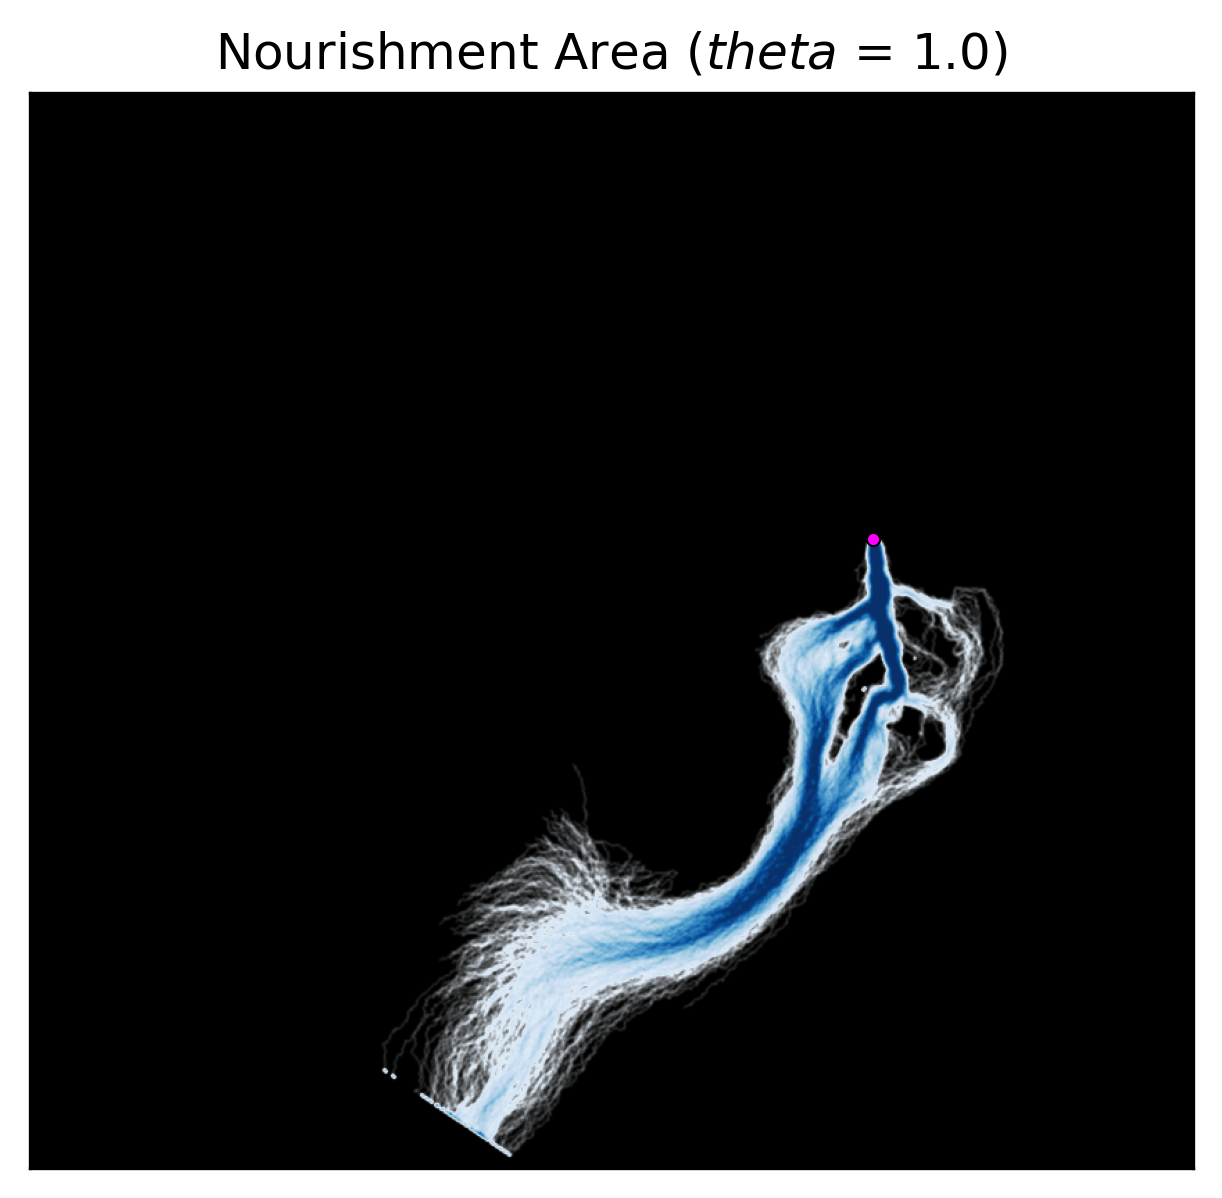

In [22]:
# compute the frequency of particles entering each grid cell (relative nourishment)
visit_freq = pt.nourishment_area(walk_data, params.topography.shape, sigma=0.8)

# plot the map of nourishment using the show_nourishment() function
fig = plt.figure(figsize=(5,5), dpi=300)
ax = drt.show_nourishment_area(visit_freq, params.topography, walk_data=walk_data, 
                               cmap='Blues', seed_color='magenta')
ax.set_xticks([],[])
ax.set_yticks([],[])

# set the title and save the figure
plt.title('Nourishment Area ($theta$ = %s)' % (theta))
plt.savefig(os.path.join(mydir, 'NourishmentArea_t%s.png' % (theta)),
            bbox_inches='tight')

The Nourishment Area plot shows regions colored depending on how frequently each cell was occupied by particles. Because we are often interested in where particles can go in general, rather than exactly where they have gone, by default this function will perform a small amount of Gaussian filtering, to smooth out some of the stochasticity in the travel paths. This smoothing can be turned off or ramped up depending on the application. 

Because the Nourishment Area is a time-integrated measure of where particles are going, we may also want to know how long particles tend to stay there once they get there. For this question, we have provided a second function, which we are calling the Nourishment Time, which computes how long on average particles spend in each cell they travel through. 

#### Nourishment times

We compute nourishment times by calling on the *nourishment_time* function, and visualize the results using the *show_nourishment_time* routine.

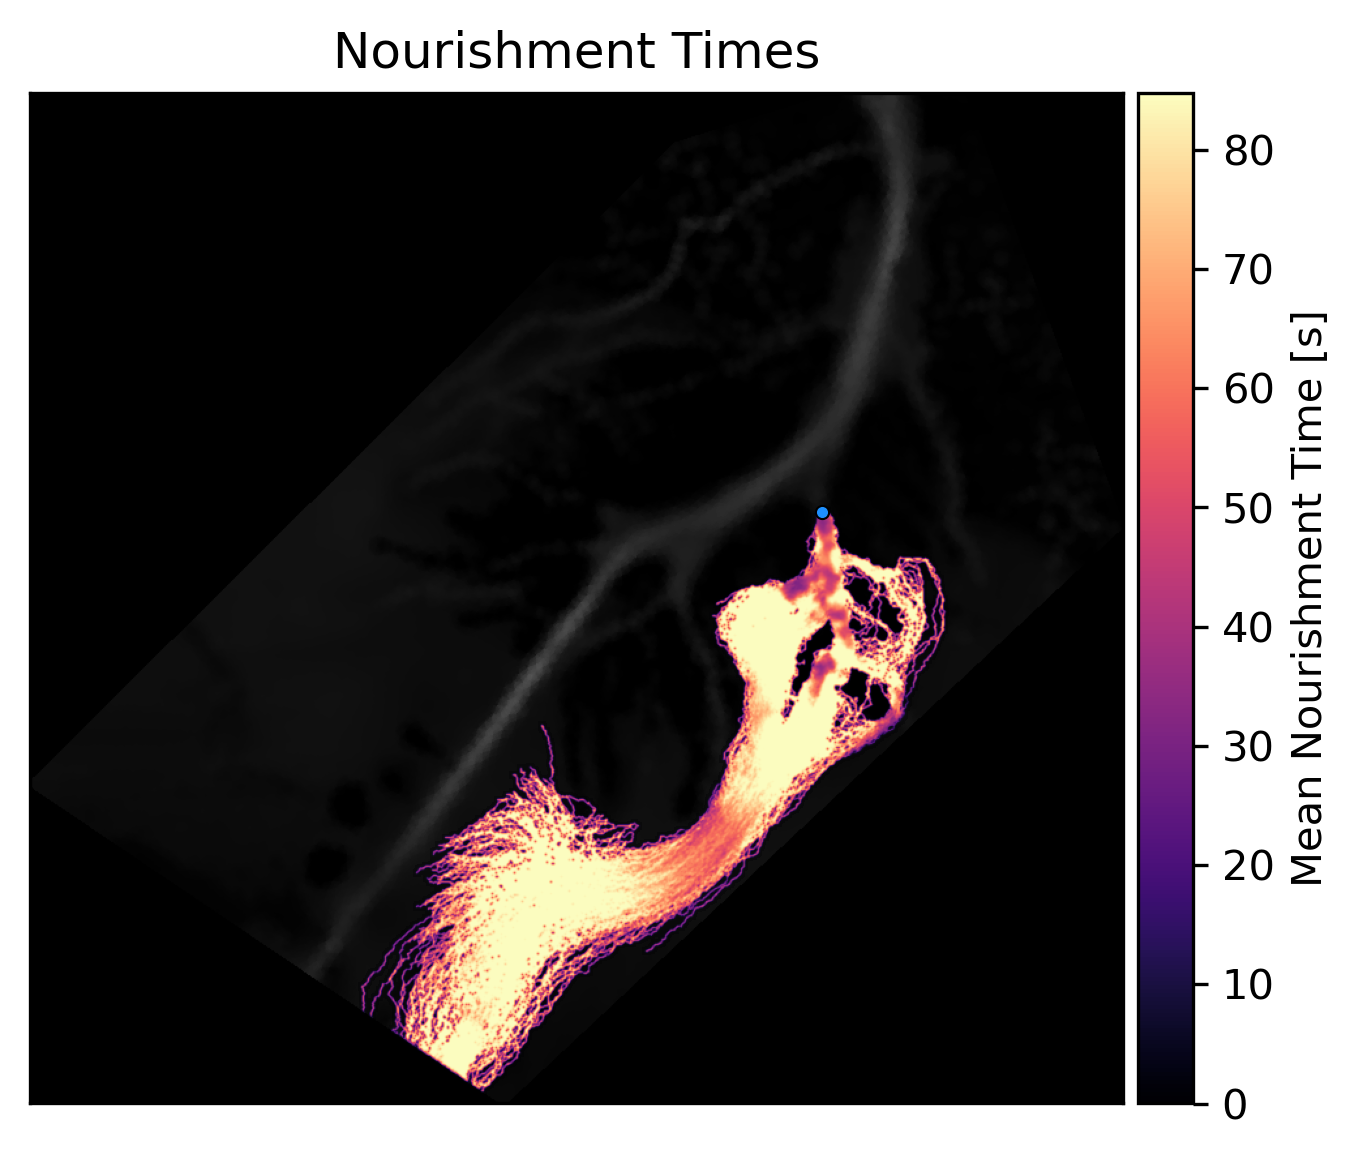

In [23]:
# close previous figure
plt.close()

# calculate the time that particles spend in each grid cell (residence time per particle)
mean_times = pt.nourishment_time(walk_data, params.depth.shape, clip=95)

# plot the map of nourishment time using the show_nourishment_time() function
fig = plt.figure(figsize=(5,5), dpi=300)
ax = drt.show_nourishment_time(mean_times, params.depth, walk_data)

ax.set_xticks([],[])
ax.set_yticks([],[])

# save the figure
plt.savefig(os.path.join(mydir, 'NourishmentTime_t%s.png' % (theta)),
            bbox_inches='tight')

#### Plot travel paths in the domain

/opt/anaconda3/envs/anuga_dx/lib/python3.9/site-packages/dorado/routines.py:786: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(particles_to_follow == 'all'):
100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2647.58it/s]


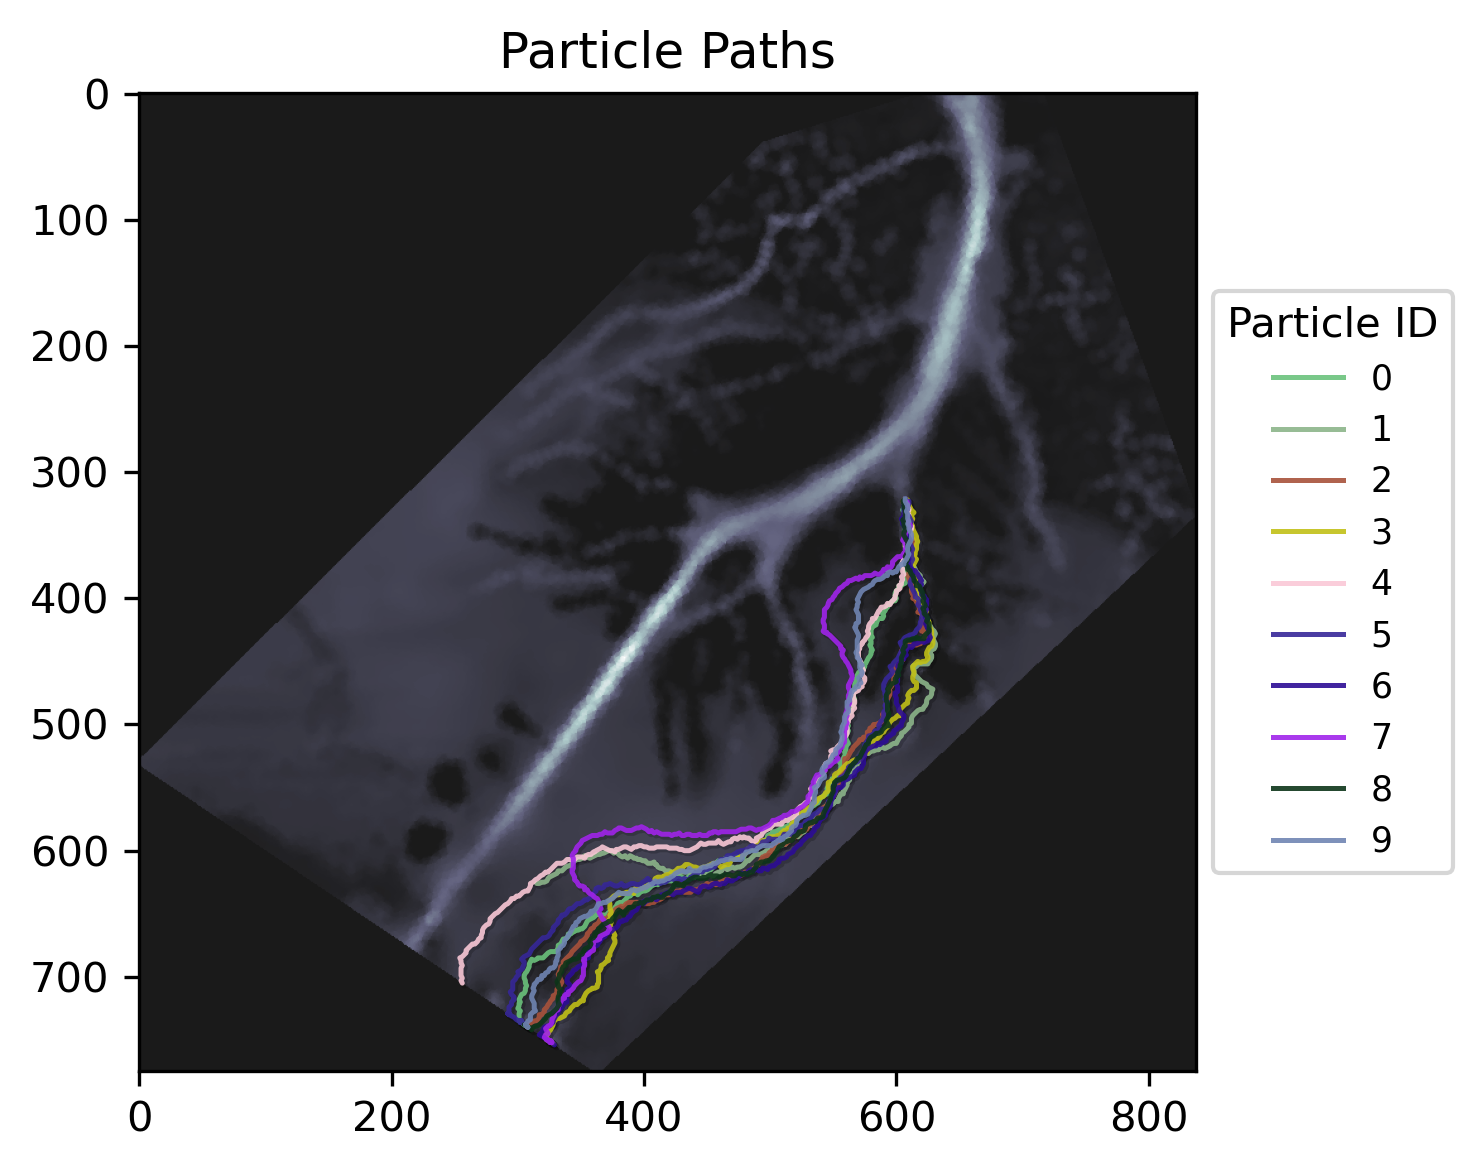

In [24]:
# close previous figure
plt.close()

# plot the travel path by giving the ID of each particle
drt.draw_travel_path(params.depth, walk_data, np.arange(0,10), os.path.join(mydir, 'Travel_paths_t%s.png' % (theta)),interval=2, plot_legend=True)

#### Assess exposure time of an area to particles

For something a little more interesting, let’s measure the amount of time particles spent “exposed” to a specific sub-region within our domain. For this we make use of the functions particle_track.exposure_time() and routines.plot_exposure_time(). If we input a binary array (same size as input arrays) delineating our region of interest (ROI) with 1’s, these functions will compute and plot the exposure time distribution (ETD) of particles in this sub-region.

For those familiar with the metric, the ETD is equivalent to the residence time distribution (RTD) for steady flows, with the only difference being that if particles make multiple excursions into our ROI, all those times are counted.

Note: For a representative ETD, it is important to run a lot of particles. A large sample size is needed to obtain a realistic distribution (and smooth plots). Depending on the domain, we recommend at least O($10^3$)

Here we are interested in the distribution of how often particles enter the wetlands at elevations above 0 m. Alternatively, one could have defined the roi also based on the friction classification or mean water levels. First, let’s generate and visualize the ROI:

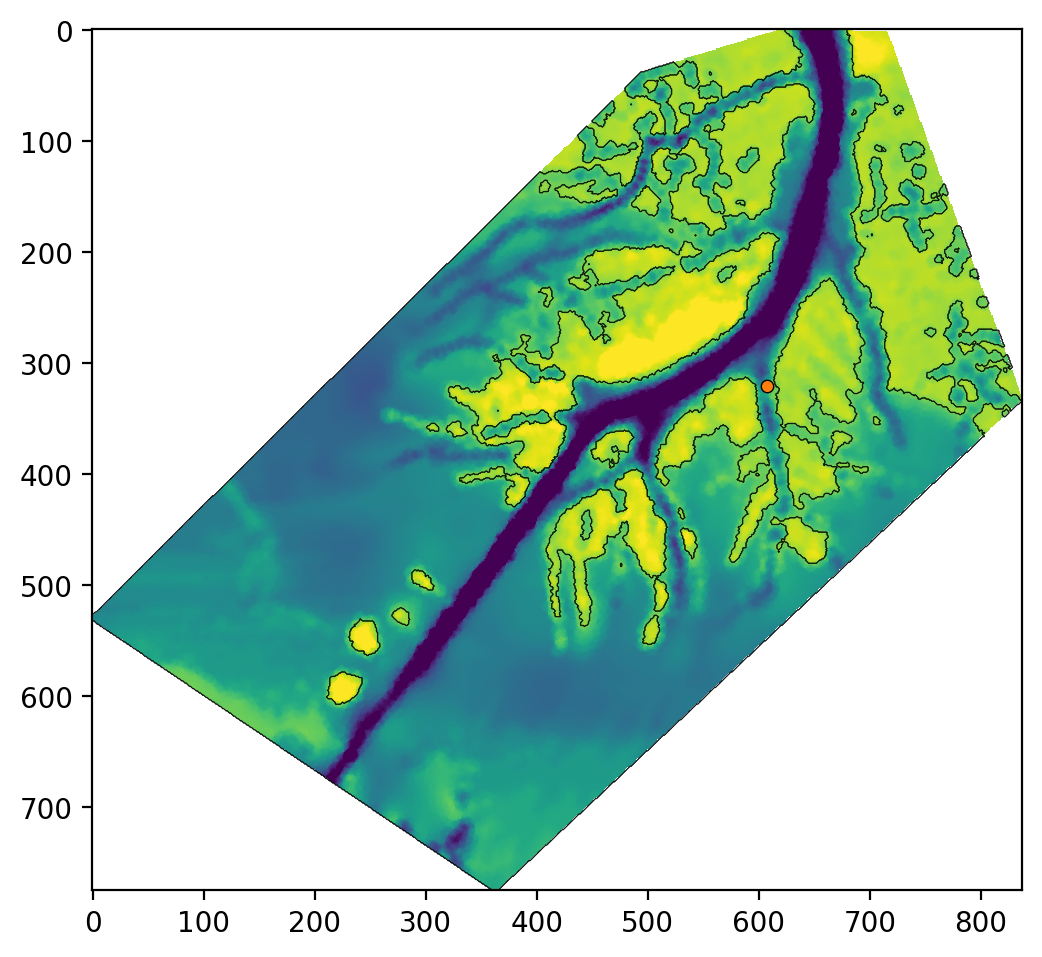

In [25]:
# define region of interest
roi =  np.ones(params.topography.shape)

# define a threshold to extract area of interest (here we look at elevations above 0 m)
roi[params.topography<0] = 0

# plot the roi
plt.figure(figsize=(6,6), dpi=200)
plt.imshow(bathy, vmin = -4, vmax = 1)
plt.contour(np.arange(roi.shape[1]),np.arange(roi.shape[0]),roi, colors = 'black',linewidths = 0.1)
for ii in range(len(seed_locs)):
    plt.scatter(seed_locs[ii][1], seed_locs[ii][0], c='tab:orange',
                                edgecolors='black', s=20, linewidths=0.5)

Then compute. exposure_time() outputs a list of exposure times by particle index, and plot_exposure_time() will use those values to generate plots of the cumulative and differential forms of the ETD (i.e. the CDF and PDF, respectively).


In [26]:
# Measure exposure times
exposure_times = pt.exposure_time(walk_data, roi, verbose=True)

print(exposure_times)

100%|#####################################| 1200/1200 [00:00<00:00, 3502.46it/s]

32 Particles within ROI at final timestep.
Particles are: [547, 592, 709, 771, 773, 774, 785, 806, 808, 812, 821, 833, 840, 848, 925, 937, 975, 989, 993, 1019, 1070, 1074, 1103, 1104, 1121, 1122, 1123, 1126, 1127, 1130, 1136, 1143]
Run more iterations to get full tail of ETD.
[543.6947593703105, 3112.7090902729847, 19.481449343996474, 1038.559073894863, 940.5666239959507, 362.3356156308241, 0.0, 0.0, 0.0, 745.5778932564644, 64.01805616116553, 0.0, 182.22776820554157, 0.0, 361.55651982833433, 7491.045450700629, 0.0, 0.0, 0.0, 535.009780964433, 0.0, 0.0, 49.719045635595194, 5720.156542754745, 322.5653596958201, 0.0, 513.2955185178494, 0.0, 0.0, 196.11501878935542, 0.0, 1283.4599507211694, 33.18515829682656, 0.0, 0.0, 0.0, 93.70584836687021, 847.8081997948095, 0.0, 2801.772314408882, 359.57503216817827, 2408.064857948212, 23107.37447608164, 194.1421566573033, 0.0, 1419.8118805846261, 5461.2811703809875, 0.0, 0.0, 1944.5643993590218, 926.3728878413808, 1019.2261765761568, 0.0, 0.0, 5916.43

Saving files in existing directory


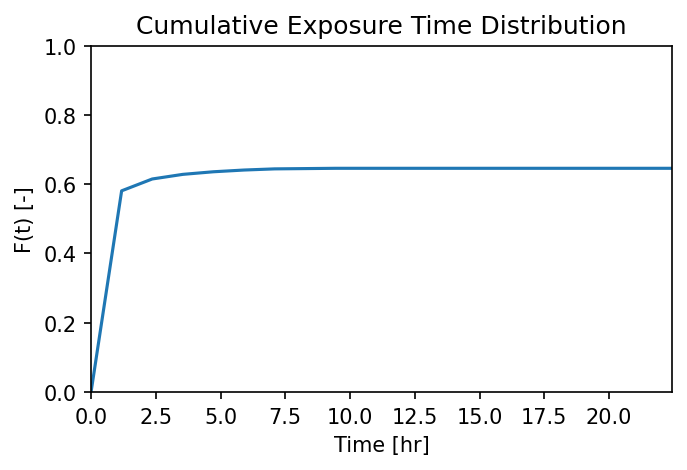

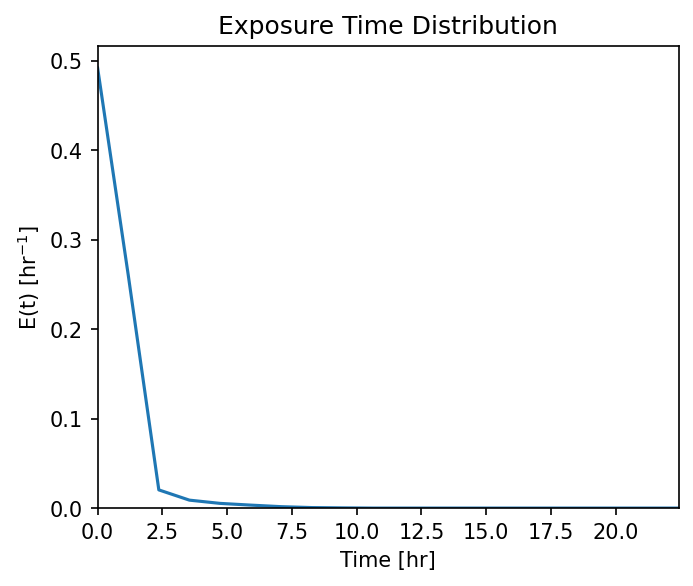

In [27]:
# Then generate plots and save data
exposure_times = drt.plot_exposure_time(walk_data,
                                                    exposure_times,
                                                    os.path.join(mydir, 'exposure_times%s.png' % (theta)),
                                                    timedelta = 3600, nbins=20)
# Changing 'timedelta' will change the units of the time-axis.
# Units are seconds, so 60 will plot by minute.
# Because we are using fewer particles than ideal, smooth the plots with small 'nbins'

**Note**: If any particles are still in the ROI at the end of their travel history, they are excluded from plots. These particles are not done being “exposed,” so we need to run more iterations in order to capture the tail of the distribution.